# Analiza tekstów medycznych: rozpoznawanie jednostek medycznych i klasyfikacja dokumentów za pomocą NLP

## 1. Import bibliotek

In [157]:
import pandas as pd
import numpy as np
import re
import string

import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid")

## 2. Import i inspekcja danych

In [158]:
data_path = 'cwiczenie2-dane.csv'
df = pd.read_csv(data_path)

df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'cwiczenie2-dane.csv'

In [ ]:
df['label'].value_counts()

label
cardio    5
pulmo     5
Name: count, dtype: int64

## 3. Wst?pne przetwarzanie tekstu

In [ ]:
import spacy
from spacy.cli import download

try:
    spacy.load("en_core_web_sm")
except OSError:
    download("en_core_web_sm")


In [ ]:
nlp = spacy.load('en_core_web_sm')

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def lemmatize_text(text: str) -> str:
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.lemma_.strip() != '']
    return ' '.join(lemmas)

df['text_clean'] = df['text'].astype(str).apply(clean_text)
df['text_lemma'] = df['text_clean'].apply(lemmatize_text)

df[['text', 'text_lemma']].head()

,text,text_lemma
0,Patient admitted with chest pain radiating to ...,patient admit chest pain radiating arm ecg sho...
1,History of myocardial infarction 2 years ago. ...,history myocardial infarction 2 year ago echoc...
2,Persistent hypertension despite treatment. Add...,persistent hypertension despite treatment add ...
3,Post-PCI follow-up. No recurrent angina. ECG n...,post pci follow recurrent angina ecg normal li...
4,Emergency admission with palpitations and dizz...,emergency admission palpitation dizziness ecg ...


## 4. Rozpoznawanie jednostek medycznych (NER)

In [ ]:
# Model scispaCy (wymaga instalacji: pip install scispacy && python -m spacy download en_core_sci_sm)
try:
    nlp_sci = spacy.load('en_core_sci_sm')
except Exception as e:
    print('Nie uda?o si? za?adowa? en_core_sci_sm. Upewnij si?, ?e model jest zainstalowany.')
    raise e

c:\Programs\Python\3.11\Lib\site-packages\spacy\util.py:969: UserWarning: [W095] Model 'en_core_sci_sm' (0.5.4) was trained with spaCy v3.7.4 and may not be 100% compatible with the current version (3.8.11). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [ ]:
def extract_entities(text: str):
    doc = nlp_sci(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

df['entities'] = df['text'].astype(str).apply(extract_entities)
df[['text', 'entities']].head()

,text,entities
0,Patient admitted with chest pain radiating to ...,"[(Patient, ENTITY), (admitted with, ENTITY), (..."
1,History of myocardial infarction 2 years ago. ...,"[(History, ENTITY), (myocardial infarction, EN..."
2,Persistent hypertension despite treatment. Add...,"[(Persistent hypertension, ENTITY), (treatment..."
3,Post-PCI follow-up. No recurrent angina. ECG n...,"[(Post-PCI, ENTITY), (follow-up, ENTITY), (No ..."
4,Emergency admission with palpitations and dizz...,"[(Emergency admission, ENTITY), (palpitations,..."


In [ ]:
# Filtrowanie encji do kategorii choroba, lek, procedura (je?li dost?pne w etykietach modelu)
target_labels = set(['DISEASE', 'DISORDER', 'CHEMICAL', 'DRUG', 'PROCEDURE'])

def filter_entities(entities):
    return [ent for ent in entities if ent[1] in target_labels]

df['entities_filtered'] = df['entities'].apply(filter_entities)

# Zliczenie najc?stszych encji
from collections import Counter

all_entities = [ent[0].lower() for ents in df['entities_filtered'] for ent in ents]
entity_counts = Counter(all_entities)
entity_counts.most_common(10)

[]

## 5. Klasyfikacja dokumentów

In [ ]:
X = df['text_lemma']
y = df['label']

print('Liczba klas:', y.nunique())
print('Rozk?ad klas:')
print(y.value_counts())

if y.nunique() < 2:
    print('Za mało klas do trenowania modelu. Dodaj co najmniej 2 różne etykiety w kolumnie label.')
else:
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
    X_vec = vectorizer.fit_transform(X)

    # Jeżeli najmniejsza klasa ma tylko 1 próbkę, nie używamy stratify
    min_class = y.value_counts().min()
    strat = y if min_class >= 2 else None

    X_train, X_test, y_train, y_test = train_test_split(
        X_vec, y, test_size=0.2, random_state=42, stratify=strat
    )

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)


Liczba klas: 2
Rozk?ad klas:
label
cardio    5
pulmo     5
Name: count, dtype: int64


## 6. Ocena modelu

In [ ]:
if 'y_pred' not in globals():
    print('Brak predykcji. Upewnij si?, ?e kom?rka z treningiem modelu zosta?a wykonana i ?e s? co najmniej 2 klasy.')
else:
    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    print(f'Accuracy: {acc:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')

    print('\nClassification Report:\n')
    print(classification_report(y_test, y_pred))


Accuracy: 0.5000
Precision: 0.2500
Recall: 0.5000
F1-score: 0.3333

Classification Report:

              precision    recall  f1-score   support

      cardio       0.50      1.00      0.67         1
       pulmo       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



c:\Programs\Python\3.11\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Programs\Python\3.11\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Programs\Python\3.11\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Programs\Python\3.11\Lib\site-packages\s

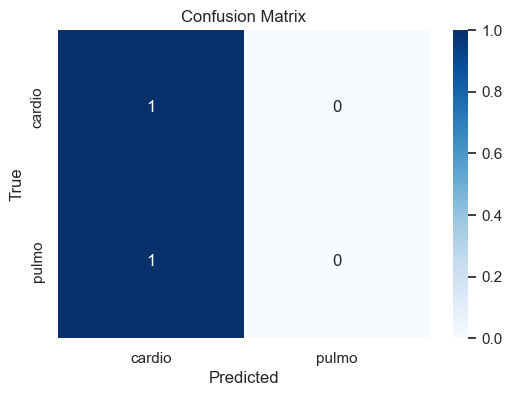

In [ ]:
if 'y_pred' not in globals() or 'clf' not in globals():
    print('Brak predykcji lub modelu. Upewnij si?, ?e kom?rka z treningiem modelu zosta?a wykonana i ?e s? co najmniej 2 klasy.')
else:
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=clf.classes_, yticklabels=clf.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


## 7. Wizualizacja NER

In [ ]:
from spacy import displacy

sample_texts = df['text'].head(2).tolist()
for i, txt in enumerate(sample_texts, start=1):
    doc = nlp_sci(txt)
    print(f'Przyk?ad {i}:')
    displacy.render(doc, style='ent', jupyter=True)

Przyk?ad 1:


Przyk?ad 2:


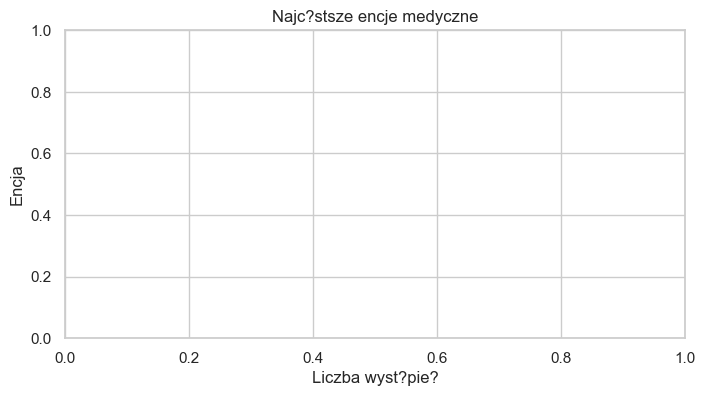

In [ ]:
# Wykres cz?sto?ci wyst?powania najpopularniejszych encji
# Je?li filtrowane encje s? puste, u?yj wszystkich encji z NER
from collections import Counter

filtered_entities = [ent[0].lower() for ents in df['entities_filtered'] for ent in ents]
if len(filtered_entities) == 0:
    print('Brak encji po filtracji ? u?ywam wszystkich encji z NER.')
    all_entities = [ent[0].lower() for ents in df['entities'] for ent in ents]
else:
    all_entities = filtered_entities

entity_counts = Counter(all_entities)
top_entities = entity_counts.most_common(10)

if len(top_entities) == 0:
    print('Brak encji do wizualizacji.')
else:
    ent_labels = [e[0] for e in top_entities]
    ent_values = [e[1] for e in top_entities]

    plt.figure(figsize=(8, 4))
    sns.barplot(x=ent_values, y=ent_labels, palette='viridis')
    plt.xlabel('Liczba wyst?pie?')
    plt.ylabel('Encja')
    plt.title('Najcz?stsze encje medyczne')
    plt.show()
